## DNN (MLP) vs LSTM

This notebook mainly compares a DNN (MLP) (1 layer) vs an LSTM for determining whether an article is clickbait from its title. We balance out the instances in each class as well.

Here: we undersample instead of oversample

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Input, Embedding, LSTM, Dropout, BatchNormalization, GRU
from keras.models import Model, Sequential
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from small_dataset import get_small_dataset
from large_dataset_title import get_large_dataset

from keras.datasets import imdb
from keras.preprocessing import sequence
from collections import Counter

from sklearn.metrics import f1_score

Using TensorFlow backend.
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mj/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtype

## Preliminaries

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
def print_cm(y_test, y_pred):
    y_test = np.array(y_test)

    y_pred_output = np.array([1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))])
    cm = confusion_matrix(y_test, y_pred_output)

    class_names = ["nonclickbait", "clickbait"]
    plot_confusion_matrix(y_test, y_pred_output, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred_output, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [5]:
# preprocess text to remove redundant things
# courtesy of https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
import re

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [6]:
"""
Code courtesy of https://keras.io/examples/pretrained_word_embeddings/
Inspiration also from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
"""
# load glove embeddings - only need to be run once
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
EMBEDDING_DIM = 100  # because using glove.6B.100

# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')

embeddings_dictionary = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_dictionary[word] = coefs

print('Found %s word vectors.' % len(embeddings_dictionary))

Indexing word vectors.
Found 400000 word vectors.


In [28]:
def plot_loss_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

## Using normal deep neural network (1 dense layer)

In [36]:
# get dataset
df = get_large_dataset()
df["title"][5]

'World Anti-Doping Agency lifts ban on Madrid laboratory'

In [37]:
# undersample majority instances (non-clickbait) to equalise number of instances
X = df["title"]
y = df["label"]
y = [1 if y[i] == '1' else 0 for i in range(len(y))]

print('Original dataset shape %s' % Counter(y))
ros = RandomUnderSampler(random_state=0)
X_reshaped = X.values.reshape(-1, 1)
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y)

print('Resampled dataset shape %s' % sorted(Counter(y_resampled).items()))

Original dataset shape Counter({0: 14777, 1: 4761})
Resampled dataset shape [(0, 4761), (1, 4761)]


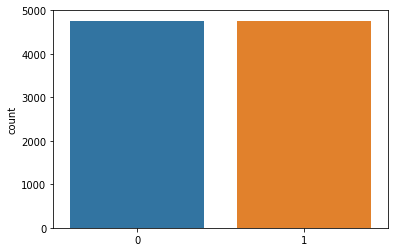

In [38]:
# visualise number of instances of each label
import seaborn as sns

sns.countplot(y_resampled)

In [ ]:
# remove punctuation etc
print(X_resampled[99])
X_processed = [preprocess_text(X_resampled[i][0]) for i in range(len(X_resampled))]
print(X_processed[99])

In [40]:
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_resampled, test_size=0.20, random_state=42)

In [41]:
# create a word-to-index dictionary
MAX_NUM_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13468 unique tokens.


In [42]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_padded = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

print('Shape of data tensor:', X_train_padded.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (7617, 100)
Shape of label tensor: (7617,)


In [44]:
# create an embedding matrix where each row number will correspond to the index of the word in the corpus
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [45]:
# set up models
dense_out = 64
dropout = 0.5
dropout_embedding = 0.2
learning_rate = 1e-5

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(dense_out, batch_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = Adam(lr=1e-5)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1346900   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,987,285
Trainable params: 640,257
Non-trainable params: 1,347,028
______________________________________

In [46]:
### Create model checkpoint
output_dir = os.getcwd()
modelcheckpoint = ModelCheckpoint(filepath = output_dir + "/DNNWeights_v5_try2.{epoch:02d}-{val_loss:.2f}.hdf5",
                                 monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [modelcheckpoint]#, EarlyStopping(monitor = "val_loss", patience = 15)]

In [47]:
#Hyper-Params
epochs = 100
batch_size = 32

# train model
history = model.fit(X_train_padded, y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split=0.2, callbacks=callbacks_list)

Train on 6093 samples, validate on 1524 samples
Epoch 1/100
6093/6093 [==============================] - 4s 585us/step - loss: 0.8911 - accuracy: 0.4909 - val_loss: 0.6996 - val_accuracy: 0.5361

Epoch 00001: val_loss improved from inf to 0.69965, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/DNNWeights_v5_try2.01-0.70.hdf5
Epoch 2/100
6093/6093 [==============================] - 3s 459us/step - loss: 0.8376 - accuracy: 0.5219 - val_loss: 0.6990 - val_accuracy: 0.5650

Epoch 00002: val_loss improved from 0.69965 to 0.69902, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/DNNWeights_v5_try2.02-0.70.hdf5
Epoch 3/100
6093/6093 [==============================] - 3s 463us/step - loss: 0.7912 - accuracy: 0.5498 - val_loss: 0.6896 - val_accuracy: 0.5886

Epoch 00003: val_loss improved from 0.69902 to 0.68962, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/DNNWeights_v5_try2.03-0.69.hdf5
Epoch 4/


Epoch 00066: val_loss did not improve from 0.62343
Epoch 67/100
6093/6093 [==============================] - 3s 535us/step - loss: 0.5386 - accuracy: 0.7220 - val_loss: 0.6283 - val_accuracy: 0.6581

Epoch 00067: val_loss did not improve from 0.62343
Epoch 68/100
6093/6093 [==============================] - 3s 500us/step - loss: 0.5375 - accuracy: 0.7258 - val_loss: 0.6304 - val_accuracy: 0.6634

Epoch 00068: val_loss did not improve from 0.62343
Epoch 69/100
6093/6093 [==============================] - 3s 517us/step - loss: 0.5358 - accuracy: 0.7315 - val_loss: 0.6315 - val_accuracy: 0.6581

Epoch 00069: val_loss did not improve from 0.62343
Epoch 70/100
6093/6093 [==============================] - 3s 481us/step - loss: 0.5340 - accuracy: 0.7295 - val_loss: 0.6305 - val_accuracy: 0.6562

Epoch 00070: val_loss did not improve from 0.62343
Epoch 71/100
6093/6093 [==============================] - 3s 474us/step - loss: 0.5311 - accuracy: 0.7346 - val_loss: 0.6322 - val_accuracy: 0.6581


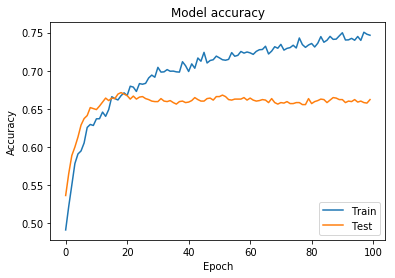

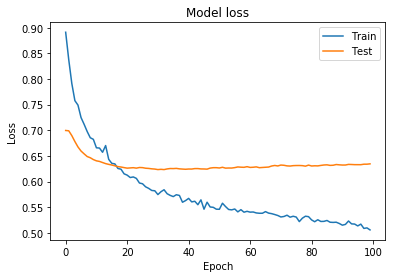

In [49]:
plot_loss_accuracy(history)

In [50]:
print(model.metrics_names)
model.evaluate(X_test_padded, y_test)

['loss', 'accuracy']
1905/1905 [==============================] - 0s 90us/step


[0.6238783690873093, 0.6682414412498474]

In [46]:

y_pred = model.predict(X_test_padded, verbose=1)

NameError: name 'model' is not defined

In [45]:
y_pred_output = [1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))]

print("F1 score: %3.5f" % f1_score(y_test, y_pred_output))

print_cm(y_test, y_pred)

NameError: name 'y_pred' is not defined

## Using LSTMs

In [11]:
# get dataset
df1 = get_large_dataset()

In [12]:
# undersample majority instances (clickbait) to equalise number of instances
X1 = df1["title"]
y1 = df1["label"]
y1 = [1 if y1[i] == '1' else 0 for i in range(len(y1))]

print('Original dataset shape %s' % Counter(y1))
ros = RandomUnderSampler(random_state=0)
X1_reshaped = X1.values.reshape(-1, 1)
X1_resampled, y1_resampled = ros.fit_resample(X1_reshaped, y1)

print('Resampled dataset shape %s' % sorted(Counter(y1_resampled).items()))

# process text
X1_processed = [preprocess_text(X1_resampled[i][0]) for i in range(len(X1_resampled))]

Original dataset shape Counter({0: 14777, 1: 4761})
Resampled dataset shape [(0, 4761), (1, 4761)]


In [13]:
# split dataset into train and test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_processed, y1_resampled, test_size=0.20, random_state=42)

In [14]:
# create a word-to-index dictionary
MAX_NUM_WORDS = 20000
tokenizer1 = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer1.fit_on_texts(X1_train)

X1_train_tok = tokenizer1.texts_to_sequences(X1_train)
X1_test_tok = tokenizer1.texts_to_sequences(X1_test)

word_index1 = tokenizer1.word_index
print('Found %s unique tokens.' % len(word_index1))

Found 13468 unique tokens.


In [15]:
# Adding 1 because of reserved 0 index
vocab_size1 = len(tokenizer1.word_index) + 1

maxlen1 = 100

X1_train_padded = pad_sequences(X1_train_tok, padding='post', maxlen=maxlen1)
X1_test_padded = pad_sequences(X1_test_tok, padding='post', maxlen=maxlen1)

print('Shape of data tensor:', X1_train_padded.shape)
print('Shape of label tensor:', y1_train.shape)

Shape of data tensor: (7617, 100)
Shape of label tensor: (7617,)


In [21]:
# create an embedding matrix where each row number will correspond to the index of the word in the corpus
embedding_matrix = np.zeros((vocab_size1, 100))
for word, index in tokenizer1.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
# set up models
lstm_out = 64
dense_out = 128
dropout = 0.4
learning_rate = 1e-4

model1 = Sequential()
model1.add(Embedding(vocab_size1, 100, weights=[embedding_matrix], input_length=maxlen1, trainable=False))
model1.add(LSTM(lstm_out))
model1.add(Dropout(dropout))
model1.add(Dense(dense_out))
model1.add(Dropout(dropout))
model1.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = Adam(lr=learning_rate)

model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model1.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1346900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,397,589
Tr

In [25]:
### Create model checkpoint
output_dir = os.getcwd()
modelcheckpoint = ModelCheckpoint(filepath = output_dir + "/try2__copy.{epoch:02d}-{val_loss:.2f}.hdf5",
                                 monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [modelcheckpoint]#, EarlyStopping(monitor = "val_loss", patience = 15)]

In [26]:
#Hyper-Params
epochs = 100
batch_size = 32

# train model
history1 = model1.fit(X1_train_padded, y1_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_split=0.2, callbacks=callbacks_list)


Train on 6093 samples, validate on 1524 samples
Epoch 1/100
6093/6093 [==============================] - 16s 3ms/step - loss: 0.6933 - accuracy: 0.4938 - val_loss: 0.6930 - val_accuracy: 0.5066

Epoch 00001: val_loss improved from inf to 0.69297, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/try2__copy.01-0.69.hdf5
Epoch 2/100
6093/6093 [==============================] - 15s 2ms/step - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6928 - val_accuracy: 0.5066

Epoch 00002: val_loss improved from 0.69297 to 0.69284, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/try2__copy.02-0.69.hdf5
Epoch 3/100
6093/6093 [==============================] - 16s 3ms/step - loss: 0.6930 - accuracy: 0.4979 - val_loss: 0.6927 - val_accuracy: 0.5066

Epoch 00003: val_loss improved from 0.69284 to 0.69273, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/try2__copy.03-0.69.hdf5
Epoch 4/100
6093/6093 [===========


Epoch 00030: val_loss improved from 0.64053 to 0.64013, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/try2__copy.30-0.64.hdf5
Epoch 31/100
6093/6093 [==============================] - 16s 3ms/step - loss: 0.6178 - accuracy: 0.6645 - val_loss: 0.6216 - val_accuracy: 0.6549

Epoch 00031: val_loss improved from 0.64013 to 0.62158, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/try2__copy.31-0.62.hdf5
Epoch 32/100
6093/6093 [==============================] - 16s 3ms/step - loss: 0.6040 - accuracy: 0.6824 - val_loss: 0.6182 - val_accuracy: 0.6601

Epoch 00032: val_loss improved from 0.62158 to 0.61819, saving model to /home/mj/Documents/School_Work/CS3244/PROJECT/CS3244Project/RNN/try2__copy.32-0.62.hdf5
Epoch 33/100
6093/6093 [==============================] - 14s 2ms/step - loss: 0.5987 - accuracy: 0.6850 - val_loss: 0.6094 - val_accuracy: 0.6640

Epoch 00033: val_loss improved from 0.61819 to 0.60937, saving model to /ho


Epoch 00067: val_loss did not improve from 0.60421
Epoch 68/100
6093/6093 [==============================] - 15s 2ms/step - loss: 0.4564 - accuracy: 0.8001 - val_loss: 0.6851 - val_accuracy: 0.6588

Epoch 00068: val_loss did not improve from 0.60421
Epoch 69/100
6093/6093 [==============================] - 14s 2ms/step - loss: 0.4556 - accuracy: 0.7991 - val_loss: 0.7034 - val_accuracy: 0.6660

Epoch 00069: val_loss did not improve from 0.60421
Epoch 70/100
6093/6093 [==============================] - 14s 2ms/step - loss: 0.4502 - accuracy: 0.8060 - val_loss: 0.7100 - val_accuracy: 0.6529

Epoch 00070: val_loss did not improve from 0.60421
Epoch 71/100
6093/6093 [==============================] - 15s 2ms/step - loss: 0.4498 - accuracy: 0.8060 - val_loss: 0.6953 - val_accuracy: 0.6601

Epoch 00071: val_loss did not improve from 0.60421
Epoch 72/100
6093/6093 [==============================] - 15s 3ms/step - loss: 0.4486 - accuracy: 0.8055 - val_loss: 0.6807 - val_accuracy: 0.6562

Epoc

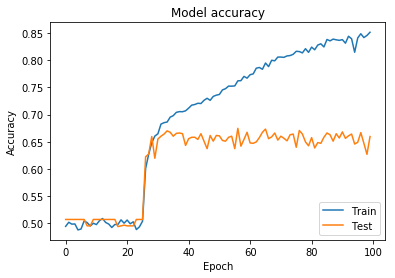

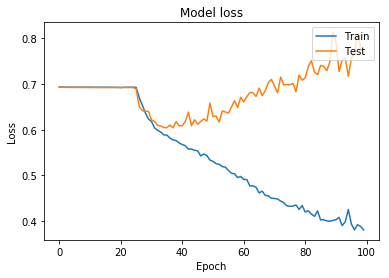

In [29]:
plot_loss_accuracy(history1)

1905/1905 [==============================] - 1s 592us/step
Confusion matrix, without normalization
[[539 434]
 [209 723]]
Normalized confusion matrix
[[0.55395683 0.44604317]
 [0.22424893 0.77575107]]


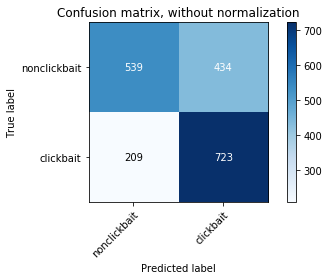

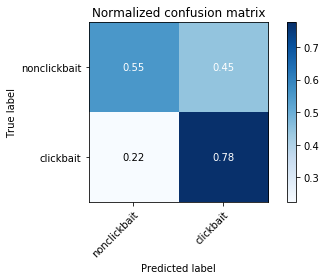

In [32]:
y1_pred = model1.predict(X1_test_padded, verbose=1)

print_cm(y1_test, y1_pred)

In [42]:
from sklearn.metrics import f1_score
y1_pred_output = [1 if y1_pred[i] > 0.5 else 0 for i in range(len(y1_pred))]

print("F1 score: %3.5f" % f1_score(y1_test, y1_pred_output))

F1 score: 0.69220


In [33]:
print(model1.metrics_names)
model1.evaluate(X1_test_padded, y1_test)

['loss', 'accuracy']
1905/1905 [==============================] - 1s 588us/step


[0.7254371929669318, 0.6624671816825867]

## Using LSTM model - best val loss model

In [8]:
# load best val loss model to compare with overfitted model above
from keras.models import load_model

wd = os.getcwd()
path = wd + "/best_models/try2__copy.38-0.60.hdf5"
model_b = load_model(path)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



1905/1905 [==============================] - 2s 1ms/step
Confusion matrix, without normalization
[[710 263]
 [329 603]]
Normalized confusion matrix
[[0.72970195 0.27029805]
 [0.35300429 0.64699571]]


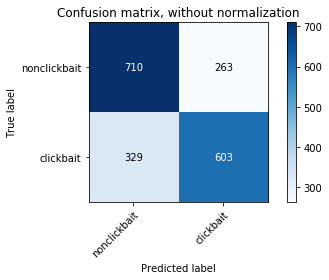

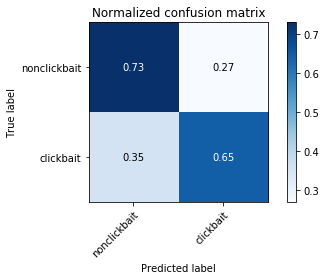

In [16]:
y_pred_b = model_b.predict(X1_test_padded, verbose=1)

print_cm(y1_test, y_pred_b)

In [17]:
y_pred_b_output = [1 if y_pred_b[i] > 0.5 else 0 for i in range(len(y_pred_b))]

print("F1 score: %3.5f" % f1_score(y1_test, y_pred_b_output))

F1 score: 0.67075


In [36]:
print(model_b.metrics_names)
model_b.evaluate(X1_test_padded, y1_test)

['loss', 'accuracy']
1905/1905 [==============================] - 1s 749us/step


[0.5875245457872005, 0.6892388463020325]

## Using DNN - best val loss model

In [9]:
# load best val loss model to compare with overfitted model above
wd = os.getcwd()
path = wd + "/best_models/DNNWeights_v5_try2.31-0.62.hdf5"
model_dnn = load_model(path)
# DNNWeights_v5_try2.31-0.62.hdf5

1905/1905 [==============================] - 0s 168us/step
Confusion matrix, without normalization
[[626 347]
 [308 624]]
Normalized confusion matrix
[[0.64337102 0.35662898]
 [0.3304721  0.6695279 ]]


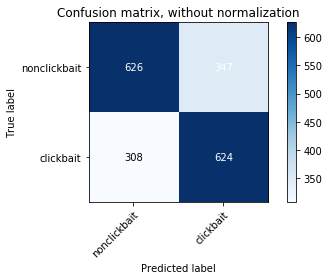

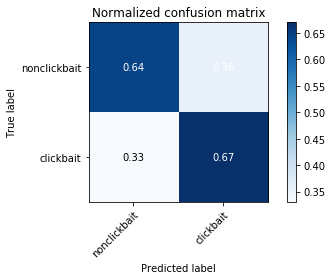

In [19]:
y_pred_dnn = model_dnn.predict(X1_test_padded, verbose=1)

print_cm(y1_test, y_pred_dnn)

In [20]:
y_pred_dnn_output = [1 if y_pred_dnn[i] > 0.5 else 0 for i in range(len(y_pred_dnn))]
print("F1 score: %3.5f" % f1_score(y1_test, y_pred_dnn_output))

F1 score: 0.65581


In [52]:
print(model_dnn.metrics_names)
model_dnn.evaluate(X1_test_padded, y1_test)

['loss', 'accuracy']
1905/1905 [==============================] - 0s 135us/step


[0.6224676029888664, 0.6561679840087891]